<a href="https://colab.research.google.com/github/arghasree/RL/blob/main/coin_flip_MDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import time

In [170]:
# Initialize: gamma, threshold, states, actions, reward
gamma = 1
threshold = 1e-10
n_states = 101

rewards = torch.zeros(n_states)
rewards[-1] = 1 # Only at state 100, the reward is 1, otherwise it is 0

Why is the discount factor 1?
- This is also called an undiscounted MDP
- Why is the discount factor less than 1? This happens when the event end is at infinity. But in this case the game ends when the state is 0 or 100+.
- So discount factor 1 is a valid option
- The second reason is that immediate reward is always 0
- A reward is only received when the game is won (state = 100+)
- Therefore all the future rewards must be considered without any further discount.  

Why is the number of states 101?
- 100 - 0 + 1 = 101 states including 0 and 100


In [171]:
# Defining env as a custom dictionary
env = {
    'max_capital' : 100,
    'head_prob' : 0.40,
    'rewards' : rewards,
    'gamma' : gamma,
    'threshold' : threshold,
    'n_states' : n_states
}

Now use the value iteration algorithm to extract the optimal policy

# Recall VI:


- VI is slower because it first calculates the optimal values of each state and then extracts the optimal policy.
- VI has 2 steps:
  - The optimal values of each states are calculated
  - The optimal policy is extracted
- Optimal value of each state:
$$V = max_a \{  ∑_{s'} P(s,a,s')[R(s,a)+ \gamma V(s') ]\}$$



In [151]:
def value_iteration(env):
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  gamma = env['gamma']
  threshold = env['threshold']
  n_states = env['n_states']

  # Initialize the value function
  V = torch.zeros(n_states)

  # For each state, each action is considered.
  # Here action = 0, 1, ... min(s, 100-s)
  while True:
    for state_id in range(1, n_states-1): # Excluding the terminal state
      V_action=[]
      V_action.append(0)  # for action 0, as the loop starts from action 1
      V_temp=V.clone()
      for action_id in range(1, min(state_id, max_capital - state_id)+1):
        # Each action can produce state s+a if they win, or s-a if they lose
        V_action.append(head_prob*(rewards[state_id+action_id] + gamma * V[state_id+action_id]) +  # if they win
                        (1 - head_prob) * (rewards[state_id-action_id] + gamma * V[state_id-action_id])) # if they lose
      V[state_id] = max(V_action)
    if torch.max(torch.abs(V - V_temp)) <= threshold:
      break


  return V

How to extract the optimal policy?
- Recall
- For each state, store an action
- For each state, calculate the values of each state for all actions, and then store the action for which the value of the state is maximum.
- The value of each state is calculated as:
$$V =   ∑_{s'} P(s,a,s')[R(s,a)+ \gamma V(s') ]$$

In [152]:
def extract_optimal_policy(env, V):
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  gamma = env['gamma']
  n_states = env['n_states']

  pi = torch.zeros(n_states)
  for state_id in range(1, n_states-1):
    Q=[]
    Q.append(0)
    for action_id in range(1, min(state_id, max_capital - state_id)+1):
      Q.append(head_prob*(rewards[state_id+action_id] + gamma * V[state_id+action_id]) +
                        (1 - head_prob) * (rewards[state_id-action_id] + gamma * V[state_id-action_id]))
    Q=torch.Tensor(Q)
    pi[state_id] = torch.argmax(Q)

  return pi


In [153]:
import time
start_time = time.time()
V_optimal = value_iteration(env)
optimal_policy = extract_optimal_policy(env, V_optimal)
print("It takes {:.3f}s to solve with value iteration".format(time.time() - start_time))

It takes 0.687s to solve with value iteration


In [154]:
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0256, 0.0256,
        0.0256, 0.0410, 0.0502, 0.0557, 0.0640, 0.0640, 0.0711, 0.0794, 0.0856,
        0.0941, 0.1024, 0.1066, 0.1154, 0.1254, 0.1332, 0.1439, 0.1600, 0.1600,
        0.1615, 0.1724, 0.1763, 0.1846, 0.1936, 0.1984, 0.2076, 0.2165, 0.2240,
        0.2353, 0.2464, 0.2560, 0.2634, 0.2707, 0.2790, 0.2899, 0.3012, 0.3136,
        0.3224, 0.3339, 0.3482, 0.3604, 0.3762, 0.4000, 0.4000, 0.4015, 0.4124,
        0.4163, 0.4246, 0.4336, 0.4384, 0.4476, 0.4565, 0.4640, 0.4753, 0.4864,
        0.4960, 0.5034, 0.5107, 0.5190, 0.5299, 0.5412, 0.5536, 0.5624, 0.5739,
        0.5882, 0.6004, 0.6162, 0.6400, 0.6413, 0.6498, 0.6602, 0.6686, 0.6784,
        0.6918, 0.7021, 0.7114, 0.7247, 0.7375, 0.7529, 0.7697, 0.7848, 0.7961,
        0.8070, 0.8212, 0.8348, 0.8517, 0.8709, 0.8842, 0.9009, 0.9225, 0.9405,
        0.9643, 0.0000])
Optimal policy:
tensor([ 0.,  0.,  0.,  0.,  3.,  5.,  6.,  6.,  8.,  9., 10., 

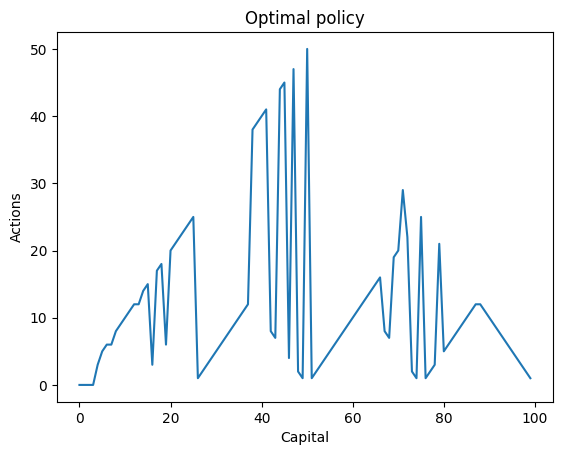

In [155]:
import matplotlib.pyplot as plt
plt.plot(optimal_policy[:100].numpy())
plt.title('Optimal policy')
plt.xlabel('Capital')
plt.ylabel('Actions')
plt.show()

# Recall PI:
- Here there is a loop between policy evaluation and policy improvement
- Policy evaluation = input a policy, calculate the value of the states by the given policy
$$V =   ∑_{s'} P(s,a,s')[R(s,a)+ \gamma V(s') ]$$
Her the action a is already given
- Policy improvement = input state values to compute new state values that maximize the old state values (see the difference)


In [83]:
def policy_evaluation(env, policy):
  """
  Perform policy evaluation
  @param env: the coin flipping gamble environment
  @param policy: policy tensor containing actions taken
  @return: values of the given policy
  """
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  gamma = env['gamma']
  n_states = env['n_states']
  threshold = env['threshold']
  V=torch.zeros(n_states)

  while True:
    V_temp=V.clone()
    for state_id in range(1, n_states-1):
      # Why does is the value not calculated for the terminal state? Because the value for that state is the maximum
      action_id = int(policy[state_id].item())
      # Usually we do the following:
      # for trans_prob, new_state, reward, _ in env.env.P[state_id][action_id]:
      #   V[state_id] += trans_prob * (reward + gamma * V[new_state])

      # But in this case we do not have the next states defined in env.env.P[state_id][action_id], so we need to do V[state_id] += trans_prob * (reward + gamma * V[new_state]) in our setting
      # What is the new state? s+a or s-a
      # What is the prob of each new states? head_prob * (s+a) or tail_prob * (s-a)
      # What is the reward after taking action a? rewards[s+a] or rewards[s-a]
      V[state_id] = head_prob * (rewards[state_id + action_id] + gamma * V_temp[state_id+action_id]) + \
                    (1-head_prob) * (rewards[state_id - action_id] + gamma * V_temp[state_id-action_id])

    if torch.max(torch.abs(V - V_temp)) <= threshold:
      break

  return V

In [161]:
def policy_improvement(env, V):
  """
  Obtain an improved policy based on the values
  @param env: the coin flipping gamble environment
  @param V: policy values
  @return: the policy
  """
  max_capital = env['max_capital']
  head_prob = env['head_prob']
  rewards = env['rewards']
  n_states = env['n_states']
  gamma = env['gamma']
  policy = torch.zeros(n_states).int()

  for state_id in range(1, n_states-1):
    # Q=[]
    # for action_id in range(1, min(state_id, max_capital - state_id)+1):
    #   Q.append(head_prob*(rewards[state_id+action_id] + gamma * V[state_id + action_id]) +
    #                       (1 - head_prob) * (rewards[state_id - action_id] + gamma * V[state_id - action_id]))
    # Q=torch.Tensor(Q)

    """
    Why the above piece of code does not work?
    Q's length is range(1, min(state_id, max_capital - state_id)+1), which is a wrong implementation, \
    as the policy chooses action 0, although it is action 1.
    """

    v_actions = torch.zeros(min(state_id, max_capital - state_id)+1)
    for action_id in range(1, min(state_id, max_capital - state_id)+1):
      v_actions[action_id] += head_prob * (
                                    rewards[state_id + action_id] +
                                    gamma * V[state_id + action_id])
      v_actions[action_id] += (1 - head_prob) * (
                                    rewards[state_id - action_id] +
                                    gamma * V[state_id - action_id])
    policy[state_id] = torch.argmax(v_actions)
  return policy

In [166]:
def policy_iteration(env, threshold):
  """
  Solve the coin flipping gamble problem with policy iteration algorithm
  @param env: the coin flipping gamble environment
  @param threshold: the evaluation will stop once values for all states are less than the threshold
  @return: optimal values and the optimal policy for the given environment
  """
  n_states = env['n_states']

  # Initialize the policy
  policy = torch.zeros(n_states).int()

  i=0
  while True:
    print(f'Iteration {i+1}', end=' ')
    i+=1
    V = policy_evaluation(env, policy)
    new_policy = policy_improvement(env, V)
    if torch.equal(policy, new_policy):
      break
    policy = new_policy

  return V, policy

In [175]:
start_time = time.time()
V_optimal, optimal_policy = policy_iteration(env, threshold)
print()
print("It takes {:.3f}s to solve with policy iteration".format(time.time() - start_time))

Iteration 1 Iteration 2 Iteration 3 Iteration 4 Iteration 5 Iteration 6 Iteration 7 Iteration 8 
It takes 5.220s to solve with policy iteration


In [176]:
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0504, 0.0577, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2579, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4979, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5740,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6608, 0.6690, 0.6791,
        0.6919, 0.7026, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7965,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9406,
        0.9643, 0.0000])
Optimal policy:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,

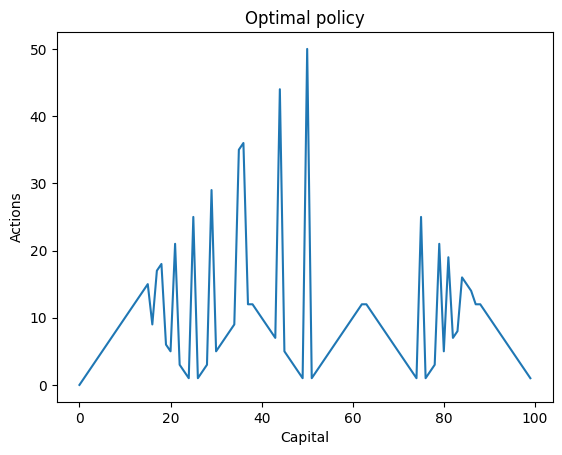

In [177]:
import matplotlib.pyplot as plt
plt.plot(optimal_policy[:100].numpy())
plt.title('Optimal policy')
plt.xlabel('Capital')
plt.ylabel('Actions')
plt.show()

Why is the V_optimal all 0s in PI and not in VI?

- Since the initial policy in PI is all zeros or all ones, it does not produce a "proper" value for all the states.
- In VI, however, the value is optimal in the sense that all actions had been considered and not just the ones mentioned in the policy.

Then how does the policy improvement work with a flawed value function in PI?
- Over iterations the value gets better